#### 참고 : tensorflow.keras 공식 문서 (Official API Docs) @ https://www.tensorflow.org/api_docs/python/tf/keras

<br>

## 1. Data loading & preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
del titanic_df['Cabin'] # 너무 많은 결측치가 존재
del titanic_df['PassengerId'] # Passenger 번호는 큰 의미를 갖고있지 않은 일련번호
del titanic_df['Ticket'] # ticket 번호에서 패턴이 확인되지 않음


titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name'] # 호칭만 남김

rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)


sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)


titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)


titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4


titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


<br>

## 2. Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [4]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [5]:
from sklearn import model_selection

train_data, test_data, train_label, test_label = model_selection.train_test_split(titanic_data, titanic_target,
                                                                                 test_size=0.3,
                                                                                 random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(623, 8)
(268, 8)
(623, 1)
(268, 1)


<br>

## 3. Change normal labels to one-hot labels

In [6]:
train_label[:5]

,Survived
857,1
52,1
386,0
124,0
578,0


In [7]:
from tensorflow.keras import utils

train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

print(train_label.shape)
print(test_label.shape)

# from sklearn import preprocessing
# enc = preprocessing.OneHotEncoder(categories='auto') 
# train_label = enc.fit_transform(train_label).toarray()
# test_label = enc.fit_transform(test_label).toarray()

(623, 2)
(268, 2)


In [8]:
train_label

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

<br>

## 4. Build & Train the model 

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [12]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=2, activation='softmax')) # One-hot vector for 0 & 1

In [13]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) 

In [14]:
history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3) 

Epoch 1/20
5/5 [==============================] - 1s 45ms/step - loss: 3.8387 - categorical_accuracy: 0.5917 - val_loss: 0.8095 - val_categorical_accuracy: 0.7647
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 1.4733 - categorical_accuracy: 0.7317 - val_loss: 0.5058 - val_categorical_accuracy: 0.8342
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.8486 - categorical_accuracy: 0.7064 - val_loss: 0.7933 - val_categorical_accuracy: 0.6952
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.8005 - categorical_accuracy: 0.7592 - val_loss: 0.4248 - val_categorical_accuracy: 0.8235
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.6095 - categorical_accuracy: 0.7683 - val_loss: 0.6744 - val_categorical_accuracy: 0.7273
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.6444 - categorical_accuracy: 0.7798 - val_loss: 0.4875 - val_categorical_accuracy: 0.8235
Epoch 7/20
5/5 [======

In [15]:
result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 2ms/step - loss: 0.4770 - categorical_accuracy: 0.8209
loss (cross-entropy) : 0.4769827425479889
test accuracy : 0.8208954930305481


In [16]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

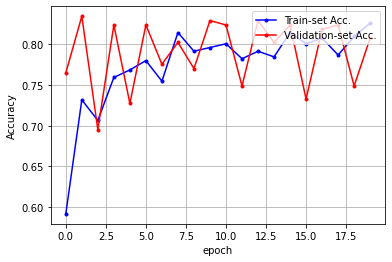

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

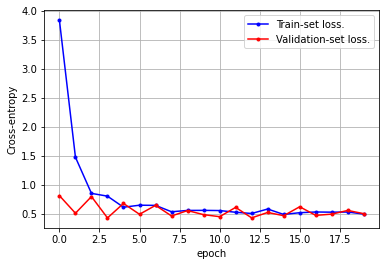

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [19]:
# 'Predict' on test data

model.predict(test_data)

array([[7.68648386e-01, 2.31351614e-01],
       [8.86494279e-01, 1.13505699e-01],
       [9.66024935e-01, 3.39750908e-02],
       [4.24151681e-03, 9.95758474e-01],
       [1.96882352e-01, 8.03117633e-01],
       [9.50700641e-01, 4.92993742e-02],
       [4.97014355e-03, 9.95029867e-01],
       [6.23104116e-03, 9.93768990e-01],
       [7.42683649e-01, 2.57316381e-01],
       [2.42811382e-01, 7.57188618e-01],
       [9.43037510e-01, 5.69624901e-02],
       [5.11798620e-01, 4.88201350e-01],
       [8.20237696e-01, 1.79762289e-01],
       [4.53120507e-02, 9.54687953e-01],
       [8.16223794e-04, 9.99183714e-01],
       [8.02236721e-02, 9.19776380e-01],
       [8.86494279e-01, 1.13505699e-01],
       [9.22686696e-01, 7.73132592e-02],
       [9.85917509e-01, 1.40824560e-02],
       [2.08211895e-02, 9.79178786e-01],
       [9.11350310e-01, 8.86496305e-02],
       [3.57139157e-03, 9.96428668e-01],
       [8.20237696e-01, 1.79762289e-01],
       [9.50700641e-01, 4.92993742e-02],
       [6.346672

In [20]:
np.argmax(model.predict(test_data), axis=1)

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [21]:
sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]])

In [22]:
model.predict(sample_data)

array([[0.9660248 , 0.03397512]], dtype=float32)

In [23]:
np.argmax(model.predict(sample_data), axis=1)

array([0], dtype=int64)